In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [3]:
# Load dataset
df = pd.read_csv(r"data\data_trustpilot.csv") 
df.head()


,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,...,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded
0,5,CA,Rob Crane,2,Redirected,repeat,1,Flashbay,The company rep I worked with made my transact...,company rep worked made transaction smooth qui...,...,2024-10-23 04:17:44,2024-10-22,10,21,Evening,1,Business Day,129,late_review,0
1,5,US,Pat Anderson,1,Verified,one-time,0,Flashbay,I highly recommend using Flashbay. Immediately...,highly recommend using flashbay immediately or...,...,2024-10-16 19:34:05,2024-10-16,10,12,Business Hours,2,Business Day,0,quick_review,1
2,5,CZ,Margarita Orlova,1,Verified,one-time,0,Flashbay,I had the pleasure of working with Shelby Gibs...,pleasure working shelby gibson large order nee...,...,2024-10-17 10:27:44,2024-10-17,10,10,Business Hours,3,Business Day,7,late_review,0
3,5,US,Paola Rivas,1,Verified,one-time,0,Flashbay,I had a fantastic experience with Brian Truong...,fantastic experience brian truong attentive tr...,...,2024-10-21 22:38:50,2024-10-21,10,15,Business Hours,0,Business Day,0,quick_review,1
4,5,CA,Fiona Mckelvey Keenan,3,Not Verified,repeat,1,Flashbay,My number-one go-to for computer accessories. ...,numberone goto computer accessories rachel sup...,...,2024-10-23 04:09:05,2024-10-22,10,21,Evening,1,Business Day,103,late_review,0


In [4]:
df["rating"].value_counts()

rating
5    31372
1    16152
4     6290
3     6272
2     4324
Name: count, dtype: int64

In [5]:
# Find the size of the smallest class
smallest_class_size = df['rating'].value_counts().min()

# Separate the classes based on ratings
rating_1 = df[df['rating'] == 1]
rating_3 = df[df['rating'] == 3]
rating_4 = df[df['rating'] == 4]
rating_5 = df[df['rating'] == 5]
other_ratings = df[df['rating'] == 2]

# Downsample the majority classes (ratings 1 and 5) to the smallest class size
rating_1_downsampled = rating_1.sample(n=smallest_class_size, random_state=42)
rating_3_downsampled = rating_3.sample(n=smallest_class_size, random_state=42)
rating_4_downsampled = rating_4.sample(n=smallest_class_size, random_state=42)
rating_5_downsampled = rating_5.sample(n=smallest_class_size, random_state=42)

# Combine back the dataset
df_balanced = pd.concat([rating_1_downsampled, rating_3_downsampled, rating_4_downsampled, rating_5_downsampled, other_ratings])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(df_balanced['rating'].value_counts())

rating
1    4324
4    4324
2    4324
5    4324
3    4324
Name: count, dtype: int64


In [6]:
texts = df_balanced['text_processed'].astype(str).tolist()  
ratings = df_balanced['rating'].astype(int).values  


In [7]:
# Tokenize and Convert Text to Sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  

X = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = 60  
X = pad_sequences(X, maxlen=max_length, padding='post')

# Encode ratings
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(ratings)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load GloVe Embeddings
embedding_dim = 300
glove_file = "glove.6B.300d.txt"  

embeddings_index = {}
with open(glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the RNN Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))  # Freeze GloVe embeddings
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=5, activation='softmax'))  # 5 classes for 5-star ratings

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print("Validation Accuracy: ", accuracy * 100, "%")

# Save the model
model.save("rnn_glove_rating_under.keras")


c:\Users\Admin\.conda\envs\supply_chain\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.3295 - loss: 1.4824 - val_accuracy: 0.3994 - val_loss: 1.4187
Epoch 2/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.3523 - loss: 1.4409 - val_accuracy: 0.3656 - val_loss: 1.4122
Epoch 3/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.4052 - loss: 1.3831 - val_accuracy: 0.4440 - val_loss: 1.3204
Epoch 4/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.4381 - loss: 1.3106 - val_accuracy: 0.4653 - val_loss: 1.2447
Epoch 5/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.4545 - loss: 1.2574 - val_accuracy: 0.4820 - val_loss: 1.1952
Epoch 6/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.4849 - loss: 1.1941 - val_accuracy: 0.5162 - val_loss: 1.1053
Epoch 7/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.5226 - loss: 1.0965 - val_accuracy: 0.5328 - val_loss: 1.0648
Epoch 8/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.5500 - loss: 1.0405 - 

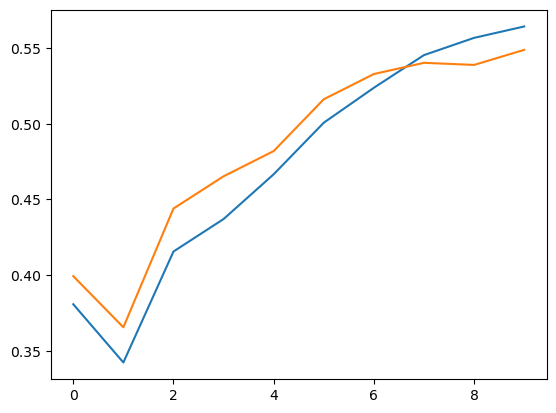

In [8]:
import matplotlib.pyplot as plt
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(train_acc)
plt.plot(val_acc)

In [9]:
y_pred = model.predict(X_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


In [10]:
import numpy as np
test_pred_class= y_pred.argmax(axis = 1)
y_test_class = y_test

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_class, test_pred_class))
print(confusion_matrix(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       850
           1       0.41      0.39      0.40       875
           2       0.43      0.38      0.41       904
           3       0.48      0.49      0.49       835
           4       0.75      0.75      0.75       860

    accuracy                           0.55      4324
   macro avg       0.54      0.55      0.55      4324
weighted avg       0.54      0.55      0.54      4324

[[634 140  47  17  12]
 [237 343 221  63  11]
 [ 73 270 345 200  16]
 [ 26  70 161 408 170]
 [ 23  14  23 157 643]]
